# ML Predictions 

Attempt at predicting time series data using standard ML models without actually doing time series. This obviously failed, but I gues is still useful in demonstrating that ML has limits and its not a solution for all (unless they failed because I'm bad).


Method:
* Trying to predict next year pollution (2015) by using the date as the input and having the model output the prediction for one the pollutants. 

Findings:
* Because of the limited data and having to predict time series, the result is not as good as the time series models in EDA
* This is still useful to discuss as we can make an excellent point that sometimes ML is an overkill, i.e. ML is not always needed and simple statistical approaches can do better
* Keep in mind the below is very rough and many of the solutions are not the best + model hyperparams aren't really optimised well, so it could use some more work but this isn't really the aim here.
* Can add more models for comparison, but not sure if its worth the time.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import linear_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.activations import tanh, relu, linear
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse

%matplotlib inline

/Users/damian/opt/anaconda3/envs/RLP2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/damian/opt/anaconda3/envs/RLP2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/damian/opt/anaconda3/envs/RLP2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/damian/opt/anaconda3/envs/RLP2

In [2]:
df = pd.read_csv('data/BathHistoricalAirSensorData.csv')

# Clean so the data is the same as EDA

In [3]:
# drop irrelevant columns
df = df.drop(['sensor_location_name', 'id', 'sensor_location_slug', 'sensor_location'], axis=1)

# rename columns
df = df.rename(columns={'nox'   : 'nitrogen_oxides (No2 + NO) ppb',
                        'no'    : 'nitrogen_monoxide (NO) ppb',
                        'no2'   : 'nitrogen_dioxide (No2) ppb',
                        'co'    : 'carbon_monoxide (CO) ppm',
                        'pm10'  : 'aerosol_particles (pm10) µg/m3',
                        'o3'    : 'ozone (o3) ppb'})


df = df.dropna(subset=['nitrogen_oxides (No2 + NO) ppb'])

df = df.drop(['ozone (o3) ppb'], axis=1)

pollutants = ['nitrogen_monoxide (NO) ppb',
              'nitrogen_dioxide (No2) ppb',
             'carbon_monoxide (CO) ppm',
             'aerosol_particles (pm10) µg/m3']

# Set index as time
df['datetime'] = pd.to_datetime(df.datetime)
df = df.set_index('datetime')
df = df.sort_index()

for p in pollutants:
    if df[p].isna().sum() > 0:
        df[p].interpolate(method='time', inplace=True)
        
df = df.dropna(subset=['aerosol_particles (pm10) µg/m3'])

df = df.drop(['nitrogen_oxides (No2 + NO) ppb'], axis=1)
        
print('\n* Null Values % of data after cleanup *')       
print(df.isna().sum()/len(df), '\n')
print('\n* Shpae *')
print(df.shape[0])


* Null Values % of data after cleanup *
nitrogen_monoxide (NO) ppb        0.0
nitrogen_dioxide (No2) ppb        0.0
carbon_monoxide (CO) ppm          0.0
aerosol_particles (pm10) µg/m3    0.0
dtype: float64 


* Shpae *
63896


In [4]:
# Keep a copy of data formatted monthly for plots later
org_data = df.resample('MS').mean()
org_data = org_data.reset_index(drop=False)
org_data['datetime'] = org_data['datetime'].astype(str).str[:-15]
org_data = org_data.to_numpy()

# Prepare data for training
data = df.reset_index(drop=False)

data['datetime'] = data['datetime'].astype(str).str[:-15]
data['datetime'] = data['datetime'].astype(str).str[-5:]
data['datetime'] = data['datetime'].str.replace('-', '').astype(int)

data = data.to_numpy()

np.random.seed(0)
shuffle = np.random.permutation(data.shape[0])
data = data[shuffle]

train_size = int(len(data) * 0.8)

train, test = data[0:train_size], data[train_size:len(data)]

train_x = train[:,:1]
train_y = train[:,1:]

test_x = test[:,:1]
test_y  = test[:,1:]

# Find unique y for classification
x_unique = np.unique(train_x)
x_unique_ct = x_unique.shape[0]

# Models

In [5]:
def DNN(x, y, output, l1_neurons, l2_neurons):
    
    model = Sequential()
    model.add(Dense(l1_neurons, activation='relu', input_shape=(1,)))   
    model.add(Dense(l2_neurons, activation='relu'))    
    model.add(Dense(output, activation='linear'))
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['accuracy']) 
    
    model.fit(x,y,verbose=0)
    
    return model

def LinearRgr(x, y):
    model = linear_model.LinearRegression()
    model.fit(x, y)
    
    return model

# Training

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


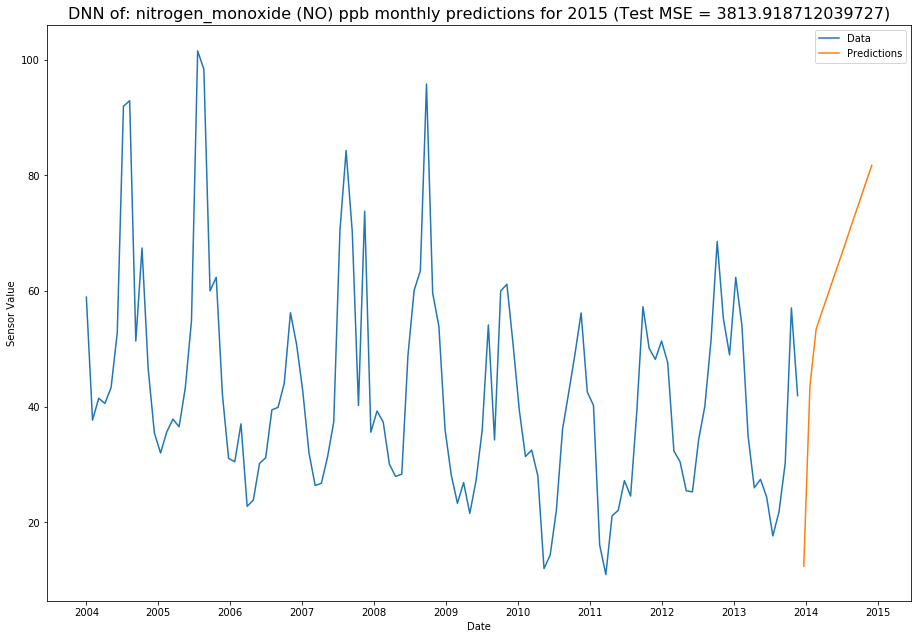

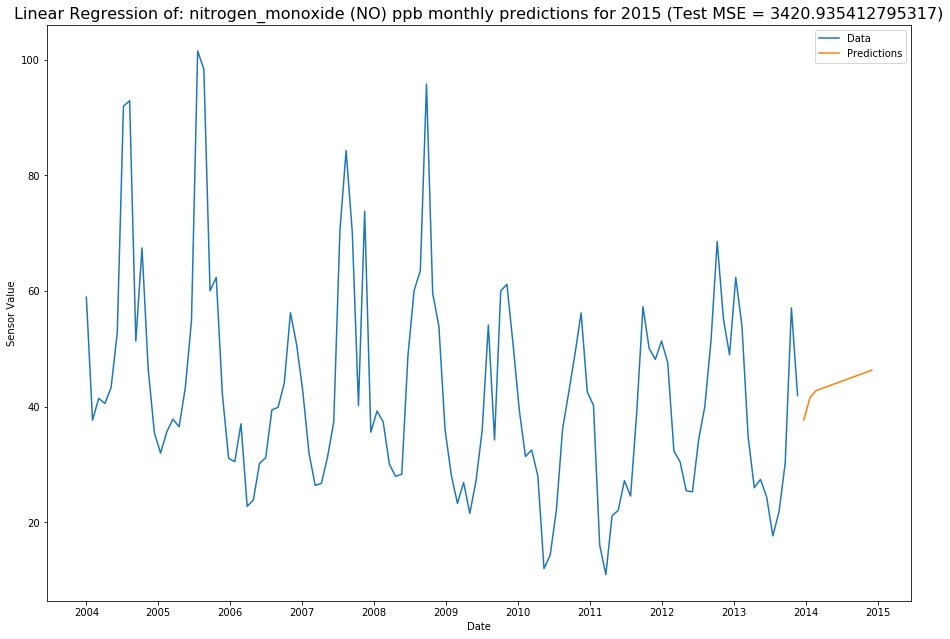

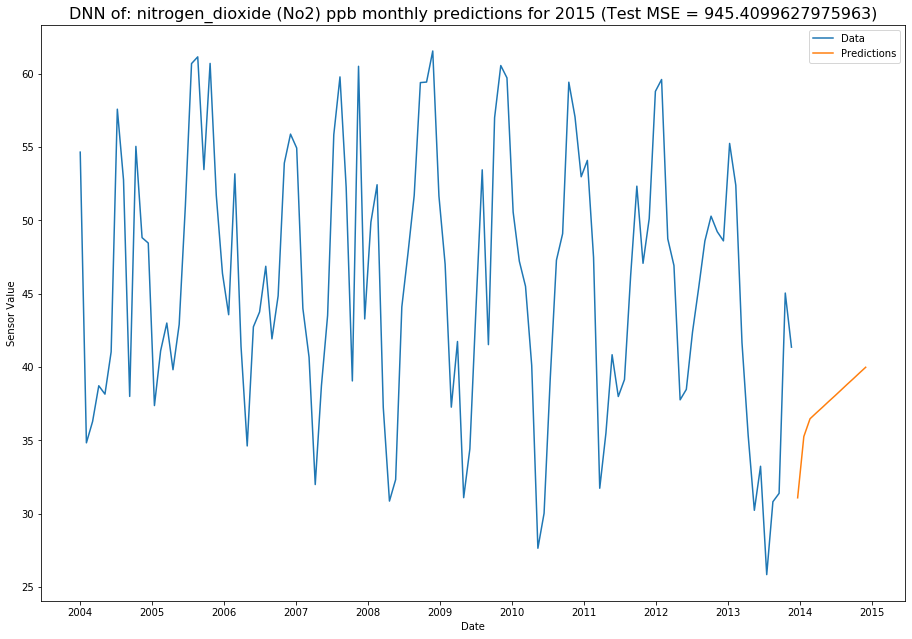

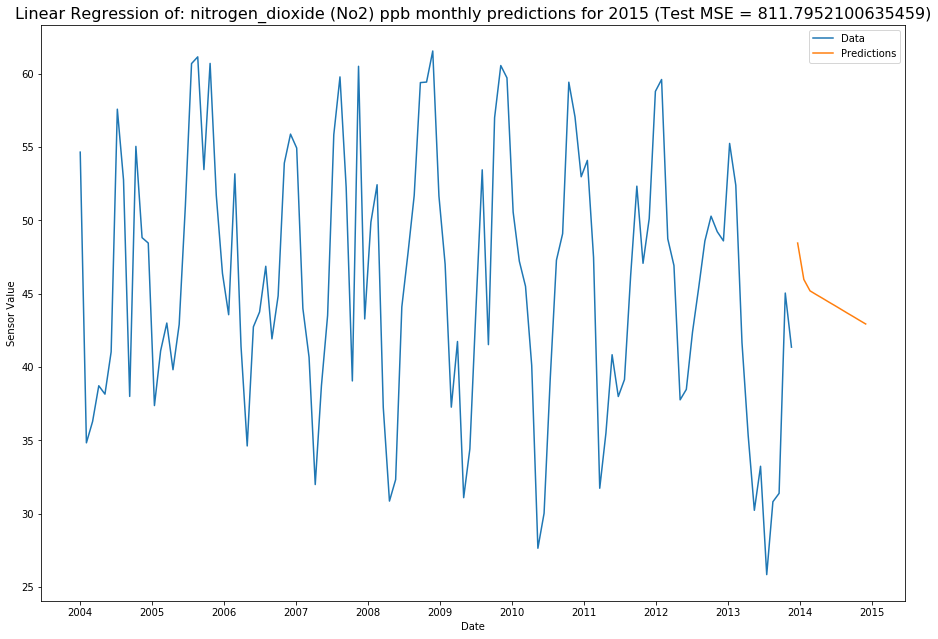

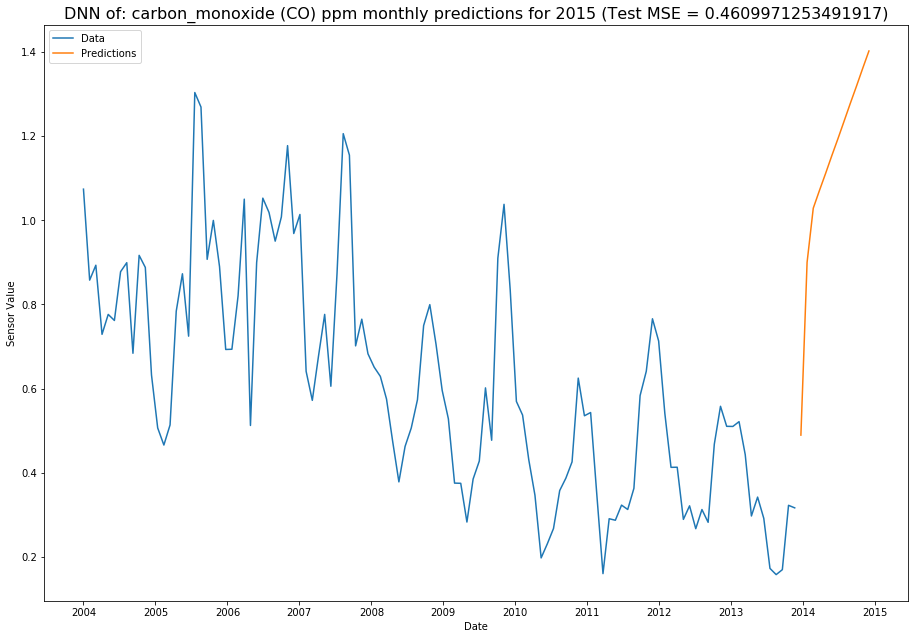

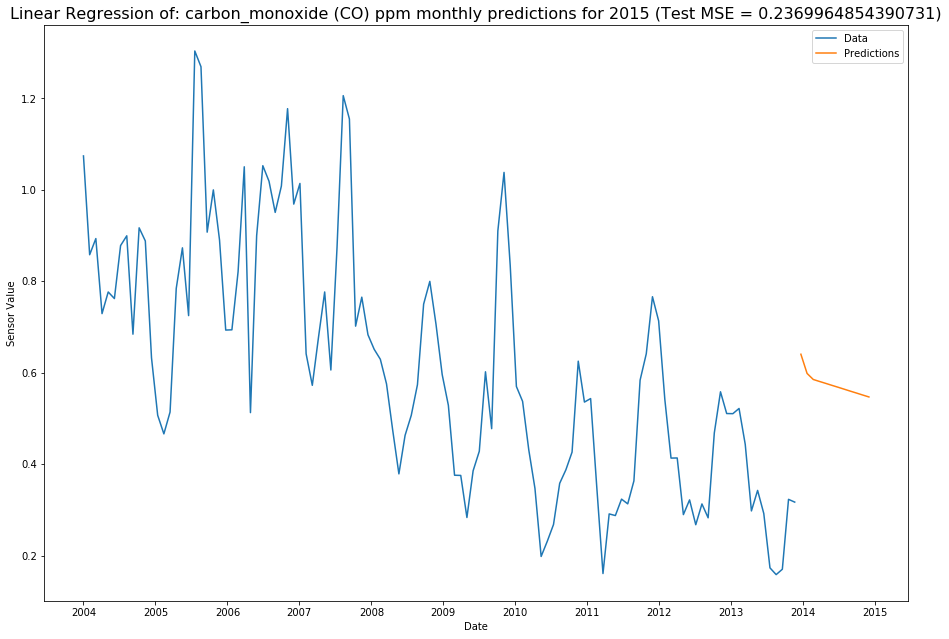

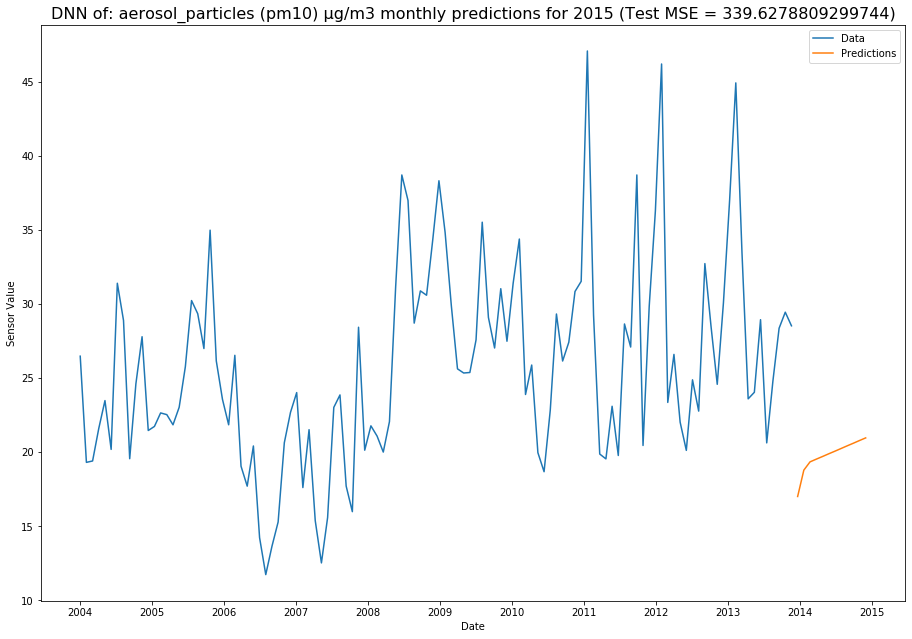

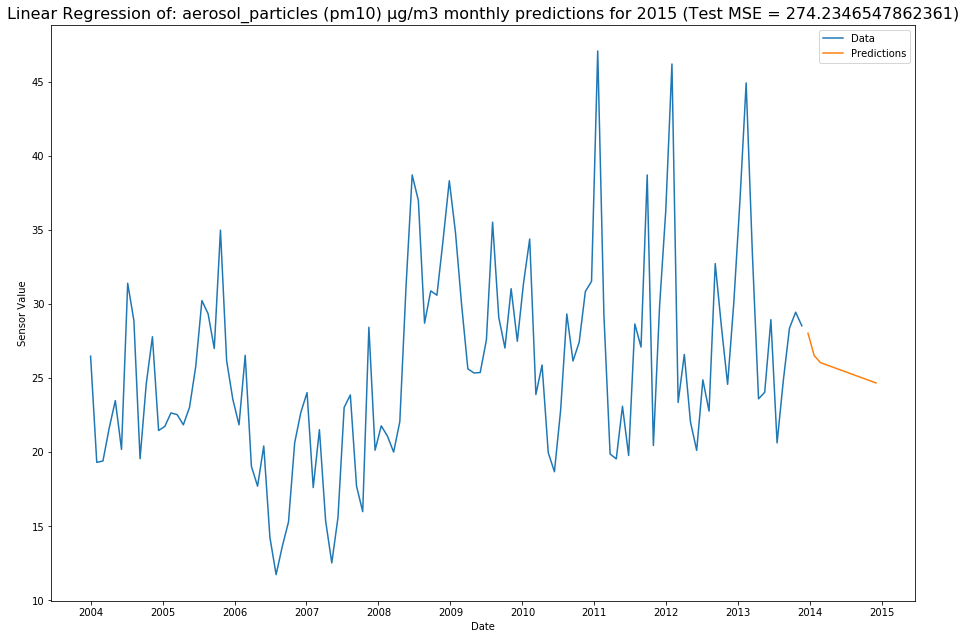

In [6]:
# Calculate the mean predicted values for each month in a year
# sorry for the horrible code, im tired lol
def convert_date(unique, preds):
    
    f_preds = np.zeros(12)
    cter = np.zeros(12)
    
    for i in range(len(unique)):
        if unique[i] < 200:
            f_preds[0] = f_preds[0] + preds[i]
            cter[0] = cter[0] + 1
            
        if unique[i] >= 200 and i < 300:
            f_preds[1] = f_preds[1] + preds[i]   
            cter[1] = cter[1] + 1             
        
        if unique[i] >= 300 and i < 400:
            f_preds[2] = f_preds[2] + preds[i] 
            cter[2] = cter[2] + 1             
        
        if unique[i] >= 400 and i < 500:            
            f_preds[3] = f_preds[3] + preds[i] 
            cter[3] = cter[3] + 1             
        
        if unique[i] >= 500 and i < 600:
            f_preds[4] = f_preds[4] + preds[i] 
            cter[4] = cter[4] + 1             
        
        if unique[i] >= 600 and i < 700:            
            f_preds[5] = f_preds[5] + preds[i] 
            cter[5] = cter[5] + 1             
        
        if unique[i] >= 700 and i < 800: 
            f_preds[6] = f_preds[6] + preds[i] 
            cter[6] = cter[6] + 1             
        
        if unique[i] >= 800 and i < 900:  
            f_preds[7] = f_preds[7] + preds[i]  
            cter[7] = cter[7] + 1             
        
        if unique[i] >= 900 and i < 1000:   
            f_preds[8] = f_preds[8] + preds[i] 
            cter[8] = cter[8] + 1             
        
        if unique[i] >= 1000 and i < 1100:            
            f_preds[9] = f_preds[9] + preds[i] 
            cter[9] = cter[9] + 1             
        
        if unique[i] >= 1100 and i < 1200: 
            f_preds[10] = f_preds[10] + preds[i] 
            cter[10] = cter[10] + 1             
        
        if unique[i] >= 1200 and i < 1300:             
            f_preds[11] = f_preds[11] + preds[i]
            cter[11] = cter[11] + 1 
        
    result = (f_preds/cter)
    return result

# Plot charts
def plots(data, x_unique, preds, model, poll, poll_id, mse):
    
    next_year_preds = convert_date(x_unique, preds)
    
    time = data[:,:1].flatten()
    
    if poll_id != 3:
        x = data[:,poll_id+1:poll_id+2].flatten()
    else:
        x = data[:,4:].flatten()   
    
    

    labels = [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015]
    next_year_dates = ['2014-01-01',
                 '2014-02-01' ,'2014-03-01' ,'2014-04-01', '2014-05-01', '2014-06-01',
                 '2014-07-01' ,'2014-08-01' ,'2014-09-01' ,'2014-10-01' ,'2014-11-01',
                 '2014-12-01']
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    ax.plot(time, x, label='Data')
    ax.plot(next_year_dates, next_year_preds, label='Predictions')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sensor Value')    
    ax.set_title(('{} of: {} monthly predictions for 2015 (Test MSE = {})'.format(model, poll, mse)), size=16)  
    ax.set_xticks(np.linspace(0,(time.shape[0]+len(next_year_dates)),len(labels)))
    ax.set_xticklabels(labels)
    plt.legend()
    plt.show()    


pollutants = ['nitrogen_monoxide (NO) ppb', 'nitrogen_dioxide (No2) ppb', 
              'carbon_monoxide (CO) ppm', 'aerosol_particles (pm10) µg/m3']

print_charts = True

# Train
for pollutant in [0,1,2,3]:

    # Select column with the right pollutant
    if pollutant != 3:
        y_train = train_y[:,pollutant:pollutant+1]
        y_test = test_y[:,pollutant:pollutant+1]
    else:
        y_train = train_y[:,3:]
        y_test = test_y[:,3:] 
        
    # Fit models
    dnn = DNN(train_x, y_train, 1, 256, 128)
    lr = LinearRgr(train_x, y_train)
    
    # Predict
    dnn_pred = dnn.predict(test_x)   
    lr_pred = lr.predict(test_x)
    
    # Performance
    mse_dnn = mean_squared_error(y_test, dnn_pred)   
    mse_lr = mean_squared_error(y_test, lr_pred) 
    
    # Plot
    if print_charts == True:
        
        dnn_new_pred = dnn.predict(x_unique.reshape(-1, 1))
        plots(org_data, x_unique, dnn_new_pred, 'DNN', pollutants[pollutant], pollutant, mse_dnn)      
        
        lr_new_pred = lr.predict(x_unique.reshape(-1, 1))
        plots(org_data, x_unique, lr_new_pred, 'Linear Regression', pollutants[pollutant], pollutant, mse_lr)
